# DLMI - Lymphocytosis classification
## One image one label models with augmented data and reduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics, model_selection
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from sklearn import metrics, model_selection
from torch.utils.data import DataLoader, Dataset


class ImageLabelDataset(Dataset):

    def __init__(self, images, labels, transform_function=None):
        self.images = images
        self.labels = labels
        self.transform_function = transform_function

    def __getitem__(self, index):
        image_path = self.images[index]
        image = image_to_numpy(image_path)
        if self.transform_function is not None:
            image = self.transform_function(image)
        return image, self.labels[index]

    def __len__(self):
        return len(self.labels)


class ImageDataset(Dataset):

    def __init__(self, images, transform_function=None):
        self.images = images
        self.transform_function = transform_function

    def __getitem__(self, index):
        image_path = self.images[index]
        image = image_to_numpy(image_path)
        if self.transform_function is not None:
            image = self.transform_function(image)
        return image

    def __len__(self):
        return len(self.images)


def image_to_numpy(image_path):
    image_pil = Image.open(image_path)
    image_np = np.array(image_pil, dtype=np.float32) / 255.0
    return image_np


def load_images(split_dir):
    images = {}

    for p in os.listdir(split_dir):
        p_dir = os.path.join(split_dir, p)
        if not os.path.isdir(p_dir):
            continue

        p_images = []
        for image_path in os.listdir(p_dir):
            p_images.append(os.path.join(p_dir, image_path))

        images[p] = p_images
    return images


def assign_labels(images_dict, labels_dict):
    images = []
    labels = []
    for p, p_images in images_dict.items():
        images.extend(p_images)
        labels.extend([labels_dict[p]] * len(p_images))
    return images, labels


def predict(model, p_dataloader, device):
    y_pred = []
    model.eval()
    with torch.no_grad():
        for X in p_dataloader:
            X = torch.FloatTensor(X).to(device)
            logits = model(X)
            pred = F.softmax(logits, dim=-1).argmax(dim=-1)
            y_pred.extend(pred.cpu().detach().numpy().tolist())
    return int(np.mean(y_pred) > .5)


def predict_all(model, images_dict, transform_function, batch_size, device):
    y_pred = []
    for p, p_images in images_dict.items():
        p_dataset = ImageDataset(p_images, transform_function)
        p_dataloader = DataLoader(p_dataset, batch_size=batch_size, shuffle=False)
        y = predict(model, p_dataloader, device)
        y_pred.append(y)
    return np.array(y_pred)


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image


def image_to_numpy(image_path):
    image_pil = Image.open(image_path)
    image_np = np.array(image_pil, dtype=np.float32) / 255.0
    return image_np


def test(model, loss_fn, dataloader, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = torch.FloatTensor(X).to(device)
            y = torch.LongTensor(y).to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    accuracy /= size
    return test_loss, accuracy


def train(model, optimizer, loss_fn, dataloader, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, accuracy = 0, 0
    for X, y in dataloader:
        X = torch.FloatTensor(X).to(device)
        y = torch.LongTensor(y).to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= num_batches
    accuracy /= size
    return train_loss, accuracy


def trainer(model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs, device=None):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, n_epochs + 1):
        train_loss, train_accuracy = train(model, optimizer, loss_fn, train_dataloader, device)
        test_loss, test_accuracy = test(model, loss_fn, test_dataloader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        if epoch % 1 == 0:
            print(f"[Epoch {epoch} / {n_epochs}] train loss = {train_loss:.4f} acc = {train_accuracy:.4f} ",
                f"test loss = {test_loss:.4f} acc = {test_accuracy:.4f}")

    return (train_losses, train_accuracies), (test_losses, test_accuracies)



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
data_dir = "/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/"
train_dir = data_dir + "trainset/"
test_dir = data_dir + "testset/"
augmented_data_dir = "/kaggle/input/dlmi-lymphocytosis-augmented/dlmi-lymphocytosis-augmented-data"

In [6]:
train_val_images = load_images(train_dir)
test_images = load_images(test_dir)

In [7]:
augmented_images = {"augmented": []}
for image_path in os.listdir(augmented_data_dir):
    augmented_images["augmented"].append(os.path.join(augmented_data_dir, image_path))

/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/testset/P93/000025.jpg
(224, 224, 3)


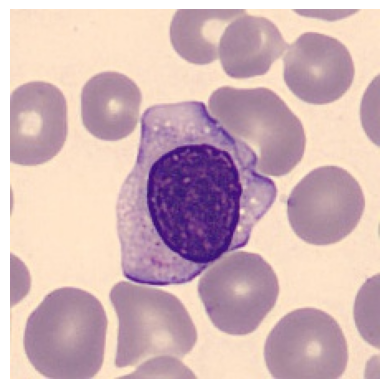

In [8]:
image_path = list(test_images.values())[5][10]
print(image_path)
image = image_to_numpy(image_path)
print(image.shape)
plt.imshow(image)
plt.axis("off")
plt.show()

In [9]:
trainset_true_df = pd.read_csv(data_dir + "trainset/trainset_true.csv")
labels_dict = dict(zip(trainset_true_df["ID"], trainset_true_df["LABEL"]))

In [25]:
n_id_val_per_class = 25

id_train_val = np.array(list(train_val_images.keys()))
labels = np.array([labels_dict[id] for id in id_train_val])

id_train_val_0 = id_train_val[labels == 0]
id_train_val_1 = id_train_val[labels == 1]

id_val_0 = np.random.choice(id_train_val_0, size=n_id_val_per_class, replace=False)
id_val_1 = np.random.choice(id_train_val_1, size=n_id_val_per_class, replace=False)

id_val = np.concatenate([id_val_0, id_val_1])
mask = np.isin(id_train_val, id_val, invert=True)
id_train = id_train_val[mask]

id_train.shape, id_val.shape

((113,), (50,))

In [26]:
train_images = {id: train_val_images[id] for id in id_train}
val_images = {id: train_val_images[id] for id in id_val}

X_train, y_train = assign_labels(train_images, labels_dict)
X_val, y_val = assign_labels(val_images, labels_dict)
len(X_train), len(X_val)

(9759, 3694)

In [27]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1062, 8697]))

In [28]:
np.unique(y_val, return_counts=True)

(array([0, 1]), array([1530, 2164]))

In [29]:
n_images = len(augmented_images["augmented"])
X_train.extend(augmented_images["augmented"][:n_images])
y_train.extend([0]*n_images)
np.unique(y_train, return_counts=True)

(array([0, 1]), array([8338, 8697]))

In [30]:
from skimage.transform import resize
def transform_function(image):
    image = resize(
        image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True
    )
    return image.reshape(3, image.shape[0], image.shape[1])

In [31]:
batch_size = 32
train_dataset = ImageLabelDataset(X_train, y_train, transform_function)
test_dataset = ImageLabelDataset(X_val, y_val, transform_function)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:


class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Sequential(
                nn.Linear(576, 128),
                nn.ReLU(),
                nn.Linear(128, 16),
                nn.ReLU(),
                nn.Linear(16, 2)
            )
        )

    def forward(self, x):
        return self.model(x)

[Epoch 1 / 100] train loss = 0.2565 acc = 0.9034  test loss = 0.7418 acc = 0.6833
[Epoch 2 / 100] train loss = 0.1890 acc = 0.9311  test loss = 0.8832 acc = 0.6115
[Epoch 3 / 100] train loss = 0.1734 acc = 0.9369  test loss = 0.6086 acc = 0.7136
[Epoch 4 / 100] train loss = 0.1666 acc = 0.9380  test loss = 1.9734 acc = 0.5855
[Epoch 5 / 100] train loss = 0.1601 acc = 0.9416  test loss = 2.5214 acc = 0.5858
[Epoch 6 / 100] train loss = 0.1576 acc = 0.9402  test loss = 1.1657 acc = 0.5907
[Epoch 7 / 100] train loss = 0.1491 acc = 0.9432  test loss = 1.2603 acc = 0.5858
[Epoch 8 / 100] train loss = 0.1472 acc = 0.9451  test loss = 0.5346 acc = 0.7504
[Epoch 9 / 100] train loss = 0.1420 acc = 0.9466  test loss = 1.0776 acc = 0.6381
[Epoch 10 / 100] train loss = 0.1378 acc = 0.9473  test loss = 0.6893 acc = 0.7618
[Epoch 11 / 100] train loss = 0.1353 acc = 0.9476  test loss = 0.8614 acc = 0.7279
[Epoch 12 / 100] train loss = 0.1290 acc = 0.9508  test loss = 1.6201 acc = 0.6199
[Epoch 13 / 1

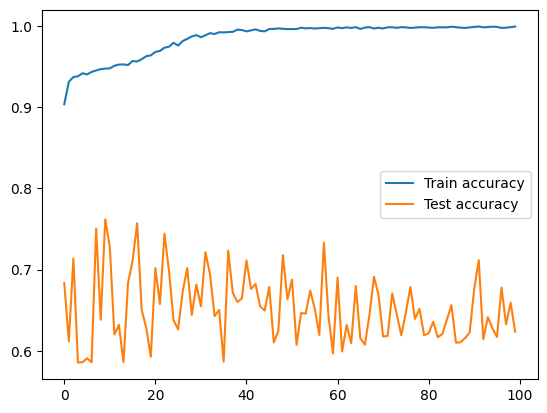

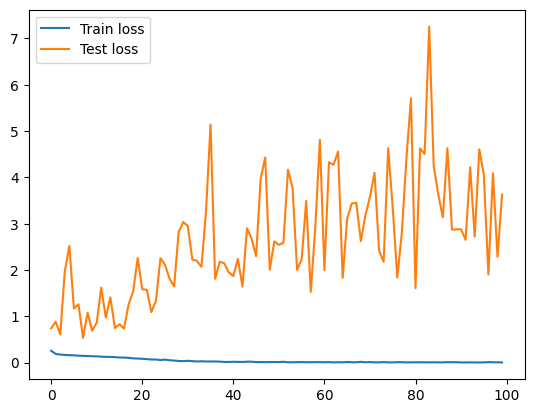

In [33]:
model = CNN().to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 100
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs, device
)

plt.figure()
plt.plot(train_accuracies, label="Train accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [34]:
def predict_all(model, images_dict, transform_function, batch_size, device):
    y_pred = []
    for p, p_images in images_dict.items():
        p_dataset = ImageDataset(p_images, transform_function)
        p_dataloader = DataLoader(p_dataset, batch_size=batch_size, shuffle=False)
        y = predict(model, p_dataloader, device)
        y_pred.append(y)
    return np.array(y_pred)

In [35]:
y_true_val = np.array([labels_dict[p] for p in val_images.keys()])
y_pred = predict_all(model, val_images, transform_function, batch_size=batch_size, device=device)

In [36]:
y_true_val, y_pred

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]))

In [37]:
acc = metrics.accuracy_score(y_true_val, y_pred)
balanced_acc = metrics.balanced_accuracy_score(y_true_val, y_pred)
print(f"acc = {acc:.2f} bal. acc = {balanced_acc:.2f}")

acc = 0.46 bal. acc = 0.53
